## Preprocessing and merging

In [1]:
import os
import anndata
import muon as mu
import scanpy as sc
import scirpy as ir
import pandas as pd
from glob import glob

base_path = "/global/scratch/users/zhoufd/TCR"
runs = ["0516", "0605"]
tissues = ["CNS", "Spleen"]

samples = {
    f"{tissue}_{run}": {
        "gex": f"{base_path}/data/{tissue}_{run}_config_5prime_2runs/outs/per_sample_outs/{tissue}_{run}_config_5prime_2runs/count/sample_filtered_feature_bc_matrix/",
        "tcr": f"{base_path}/data/{tissue}_{run}_config_5prime_2runs/outs/per_sample_outs/{tissue}_{run}_config_5prime_2runs/vdj_t/filtered_contig_annotations.csv"
    }
    for run in runs for tissue in tissues
}


adatas_tcr = {}
adatas_gex = {}

for sample, paths in samples.items():
    adata_gex = sc.read_10x_mtx(paths["gex"], var_names="gene_symbols", cache=True)
    adata_gex.var_names_make_unique()  # Ensure unique gene names

    adata_tcr = ir.io.read_10x_vdj(paths["tcr"])

    # Modify barcode index: "barcode_tissue_run"
    adata_gex.obs.index = adata_gex.obs.index + "_" + sample
    adata_tcr.obs.index = adata_tcr.obs.index + "_" + sample

    adatas_gex[sample] = adata_gex
    adatas_tcr[sample] = adata_tcr

    print(f"Loaded {sample}: GEX shape {adata_gex.shape}, TCR shape {adata_tcr.shape}")

adata_gex = anndata.concat(adatas_gex, index_unique=None)  # Merge GEX
adata_tcr = anndata.concat(adatas_tcr, index_unique=None)  # Merge TCR





/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/anndata/utils.py:349: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


Loaded CNS_0516: GEX shape (4883, 32285), TCR shape (2292, 0)
Loaded Spleen_0516: GEX shape (34604, 32285), TCR shape (27502, 0)
Loaded CNS_0605: GEX shape (28108, 32285), TCR shape (14303, 0)
Loaded Spleen_0605: GEX shape (39619, 32285), TCR shape (30871, 0)


/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [16]:
# Create multi-modal MuData object
mdata = mu.MuData({"gex": adata_gex, "airr": adata_tcr})


/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [17]:
# Extract sample information and add to `mdata.obs`
mdata.obs["sample"] = mdata.obs.index.to_series().str.rsplit("_", n=2).str[-2] + "_" + mdata.obs.index.to_series().str.rsplit("_", n=2).str[-1]


In [18]:
mdata.obs

sample
AAACCAAAGGGGAGCT-1_CNS_0516        CNS_0516
AAACCAAAGGTCGACT-1_CNS_0516        CNS_0516
AAACCAGCACGTAAAG-1_CNS_0516        CNS_0516
AAACCATTCACTACTC-1_CNS_0516        CNS_0516
AAACCATTCCTCCGGT-1_CNS_0516        CNS_0516
...                                     ...
GTTGTGGGTGGATCGC-1_Spleen_0605  Spleen_0605
GTTGTGGGTGGCTGTA-1_Spleen_0605  Spleen_0605
GTTGTGGGTGGTCCCC-1_Spleen_0605  Spleen_0605
GTTGTGGGTGTCCCTG-1_Spleen_0605  Spleen_0605
GTTGTGGGTGTTACCC-1_Spleen_0605  Spleen_0605

[107214 rows x 1 columns]

In [19]:
# Create multi-modal MuData object
mdata = mu.MuData({"gex": adata_gex, "airr": adata_tcr})

# Extract sample information and add to `mdata.obs`
mdata.obs["sample"] = mdata.obs.index.to_series().str.rsplit("_", n=2).str[-2] + "_" + mdata.obs.index.to_series().str.rsplit("_", n=2).str[-1]

# Define metadata paths
base_path = "/global/scratch/users/zhoufd/TCR"
metadata_paths = {
    "CNS": f"{base_path}/saved_data/integrated_data/CNS_cell_type_annotation.csv",
    "Spleen": f"{base_path}/saved_data/integrated_data/Spleen_cell_type_annotation.csv"
}

# Read metadata files
metadata_list = []
for tissue, path in metadata_paths.items():
    meta = pd.read_csv(path, index_col=0)  # Ensure the first column is treated as the index

    # Extract run number from the index (barcode) → `_1` means "0516", `_2` means "0605"
    meta["run_num"] = meta.index.to_series().str.split("_").str[-1].map({"1": "0516", "2": "0605"})

    # Create the correct barcode format: "AAACCAAAGGGGAGCT-1_CNS_0605"
    meta["barcode"] = meta.index.to_series().str.replace("_1", "", regex=False).str.replace("_2", "", regex=False)
    meta["barcode"] = meta["barcode"] + "_" + tissue + "_" + meta["run_num"]

    metadata_list.append(meta)

# Combine metadata from both CNS and Spleen
metadata = pd.concat(metadata_list, ignore_index=False)  # Keep original index

# Merge metadata with `mdata.obs`
mdata.obs = mdata.obs.merge(metadata, left_index=True, right_on="barcode", how="left")

# Set the index to the barcode column for consistency
mdata.obs.set_index("barcode", inplace=True)

print("Metadata merged successfully!")



/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [38]:
len(metadata)

86505

In [25]:
import os

# Define save path
save_path = f"{base_path}/saved_data/integrated_data/all_integrated_mdata.h5mu"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save MuData object
mdata.write(save_path)
print(f"MuData saved to: {save_path}")


/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData saved to: /global/scratch/users/zhoufd/TCR/saved_data/integrated_data/all_integrated_mdata.h5mu


In [27]:
print(mdata)

MuData object with n_obs × n_vars = 107214 × 32285
  obs:	'sample', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num'
  2 modalities
    gex:	107214 x 32285
    airr:	74968 x 0
      obsm:	'airr'


In [26]:
# Get common cell indices between gex and airr
common_cells = mdata.mod["gex"].obs.index.intersection(mdata.mod["airr"].obs.index)

# Subset gex to only include these cells
gex_subset = mdata.mod["gex"][common_cells, :].copy()

# Create a new MuData object to preserve alignment
mdata_new = mu.MuData({"gex": gex_subset, "airr": mdata.mod["airr"]})

# Copy previous metadata from the old mdata object
mdata_new.obs = mdata.obs.loc[mdata_new.mod["gex"].obs.index]

# Verify the new object
print(mdata_new)

MuData object with n_obs × n_vars = 74968 × 32285
  obs:	'sample', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'integrated_nn_res.2', 'seurat_clusters', 'level_2_clusters', 'manual_cell_type', 'run_num'
  2 modalities
    gex:	74968 x 32285
    airr:	74968 x 0
      obsm:	'airr'


/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [40]:
mdata_new.write(f"{base_path}/saved_data/integrated_data/all_integrated_mdata_with_TCR.h5mu")

/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


## Brief gene expression analysis on all the cells in two experimental runs

In [145]:
import matplotlib.pyplot as plt
import numpy as np

In [146]:
mdata = mu.read(f"{base_path}/saved_data/integrated_data/all_integrated_mdata_with_TCR.h5mu")


/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [147]:
# Count non-NA rows by sample
non_na_counts = mdata.obs.dropna().groupby("sample").size()

# Display the result
print(non_na_counts)


sample
CNS_0516         237
CNS_0605       13265
Spleen_0516    15042
Spleen_0605    27663
dtype: int64


/tmp/ipykernel_295384/758979681.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  non_na_counts = mdata.obs.dropna().groupby("sample").size()


In [149]:
sc.pp.log1p(mdata["gex"])
sc.pp.pca(mdata["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata["gex"])
sc.tl.umap(mdata["gex"])

In [150]:
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)

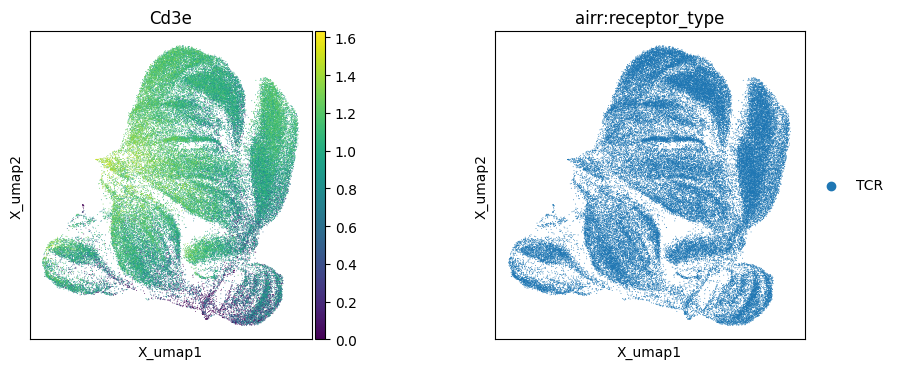

In [151]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata, basis="gex:umap", color=["Cd3e"], ax=ax0, show=False)
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)

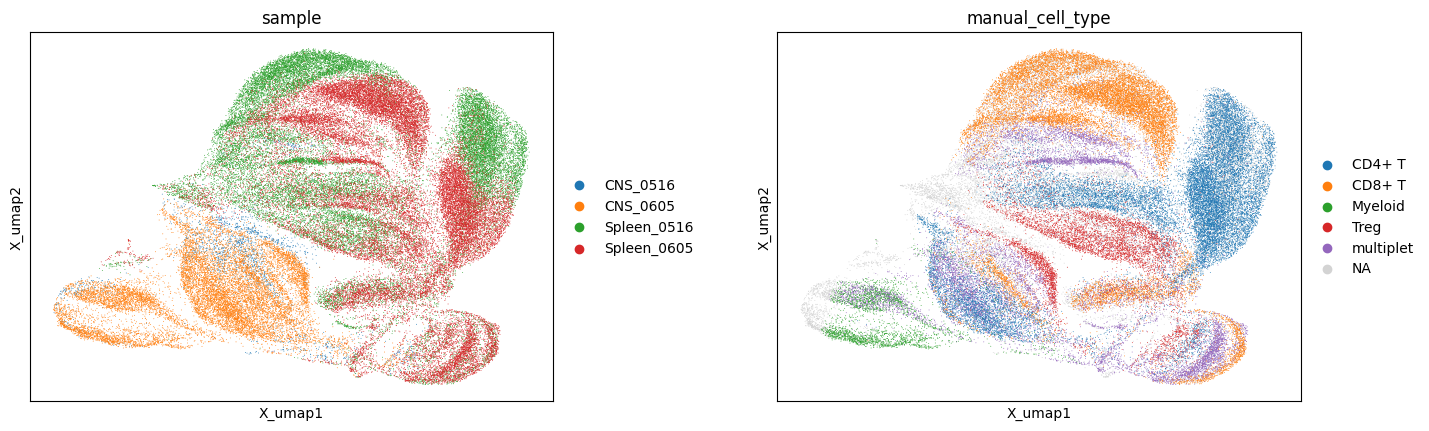

In [152]:
mu.pl.embedding(mdata, basis="gex:umap", color=['sample','manual_cell_type'],wspace=0.3,)

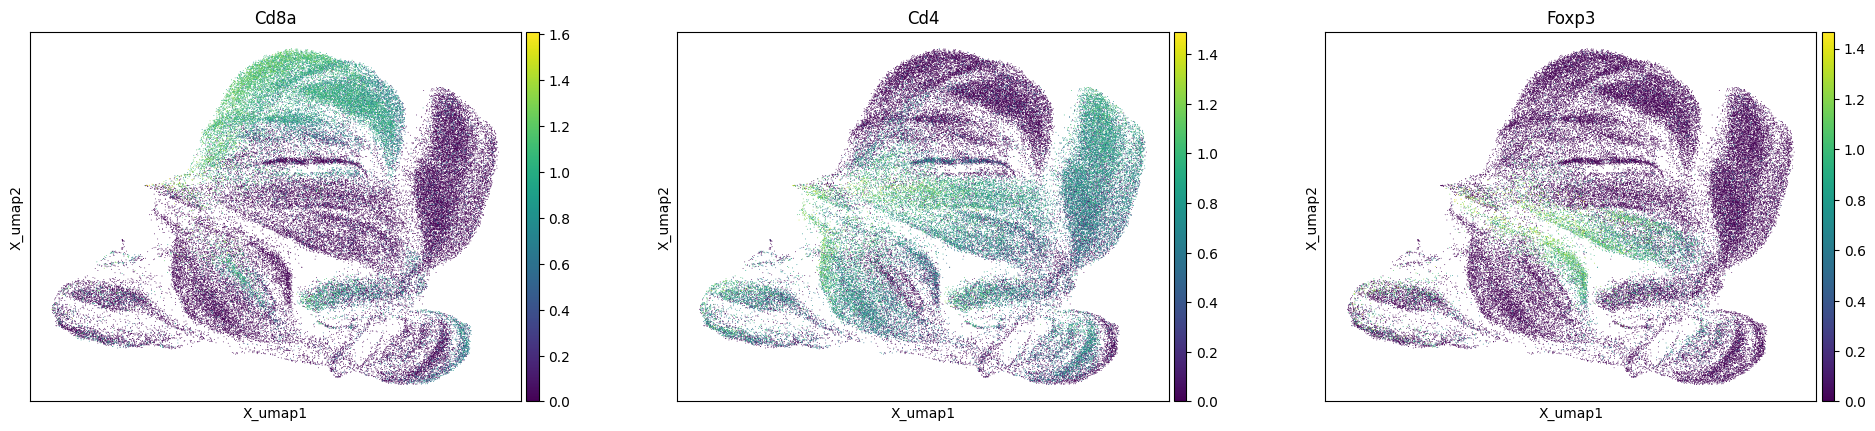

In [153]:
mu.pl.embedding(
    mdata,
    basis="gex:umap",
    color=["Cd8a", "Cd4", "Foxp3"],
    ncols=3,
    wspace=0.2,
)

### Large batch effect - only keep 0605 for TCR sequence analysis and cell types in ["CD4+ T", "Treg", "CD8+ T"] for now

This should be carefully considered

In [ ]:
mdata

In [154]:
mu.pp.filter_obs(mdata, "sample", lambda x: np.isin(x, ["CNS_0605", "Spleen_0605"]))
mu.pp.filter_obs(mdata, "manual_cell_type", lambda x: np.isin(x, ["CD4+ T", "Treg", "CD8+ T"]))

mdata.obs["sample"] = mdata.obs["sample"].cat.remove_unused_categories()
mdata.obs["manual_cell_type"] = mdata.obs["manual_cell_type"].cat.remove_unused_categories()
mdata.obs["celltype_sample"] = (
    mdata.obs["manual_cell_type"].astype(str) + "_" + mdata.obs["sample"].astype(str)
)


### Additional prefiltering - filter out "orphan VDJ", "orphan VJ"

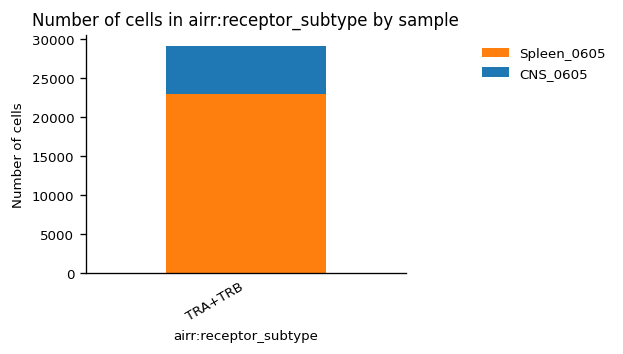

In [155]:
_ = ir.pl.group_abundance(mdata, groupby="airr:receptor_subtype", target_col="sample")

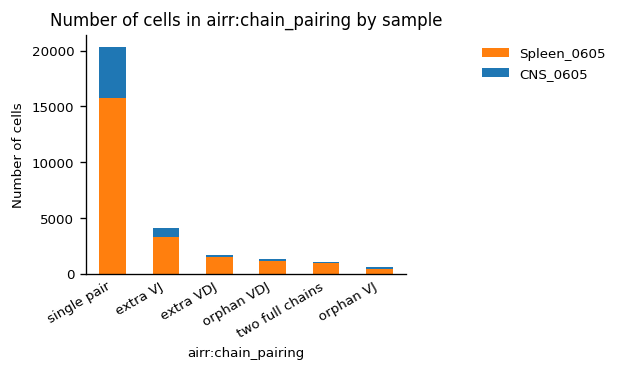

In [156]:
_ = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="sample")

In [157]:
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(mdata.obs["airr:chain_pairing"].isin(["extra VJ", "extra VDJ", "two full chains", "multichain"]))
        / mdata["airr"].n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.23


In [158]:
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ"]))

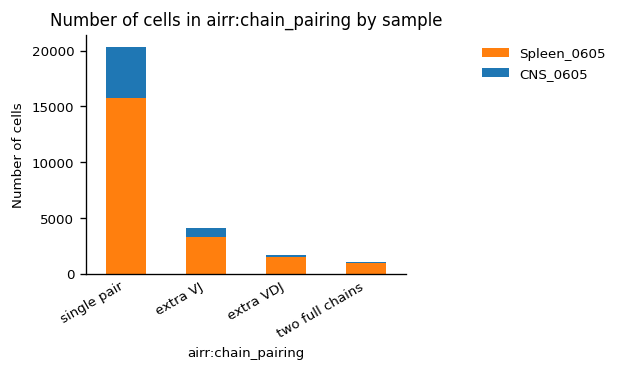

In [159]:
ax = ir.pl.group_abundance(mdata, groupby="airr:chain_pairing", target_col="sample")

## Clonotype

### Apply TCRDist for clusering the TCRs and also obtain clonotype_network

In [160]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata)
ir.tl.define_clonotypes(mdata, receptor_arms="all", dual_ir="primary_only")

In [161]:
ir.tl.clonotype_network(mdata, min_cells=10)

In [ ]:
#_ = ir.pl.clonotype_network(mdata, color="sample", base_size=20, label_fontsize=9, panel_size=(10,10))

In [162]:
## recompute clonotype

ir.pp.ir_dist(
    mdata,
    metric="tcrdist",
    sequence="aa",
    cutoff=15,
)

In [163]:
ir.tl.define_clonotype_clusters(mdata, sequence="aa", metric="tcrdist", receptor_arms="all", dual_ir="any")

In [164]:
ir.tl.clonotype_network(mdata, min_cells=10, sequence="aa", metric="tcrdist")

In [1]:
_ = ir.pl.clonotype_network(mdata, color="sample", label_fontsize=9, panel_size=(8,8), base_size=20)

NameError: name 'ir' is not defined

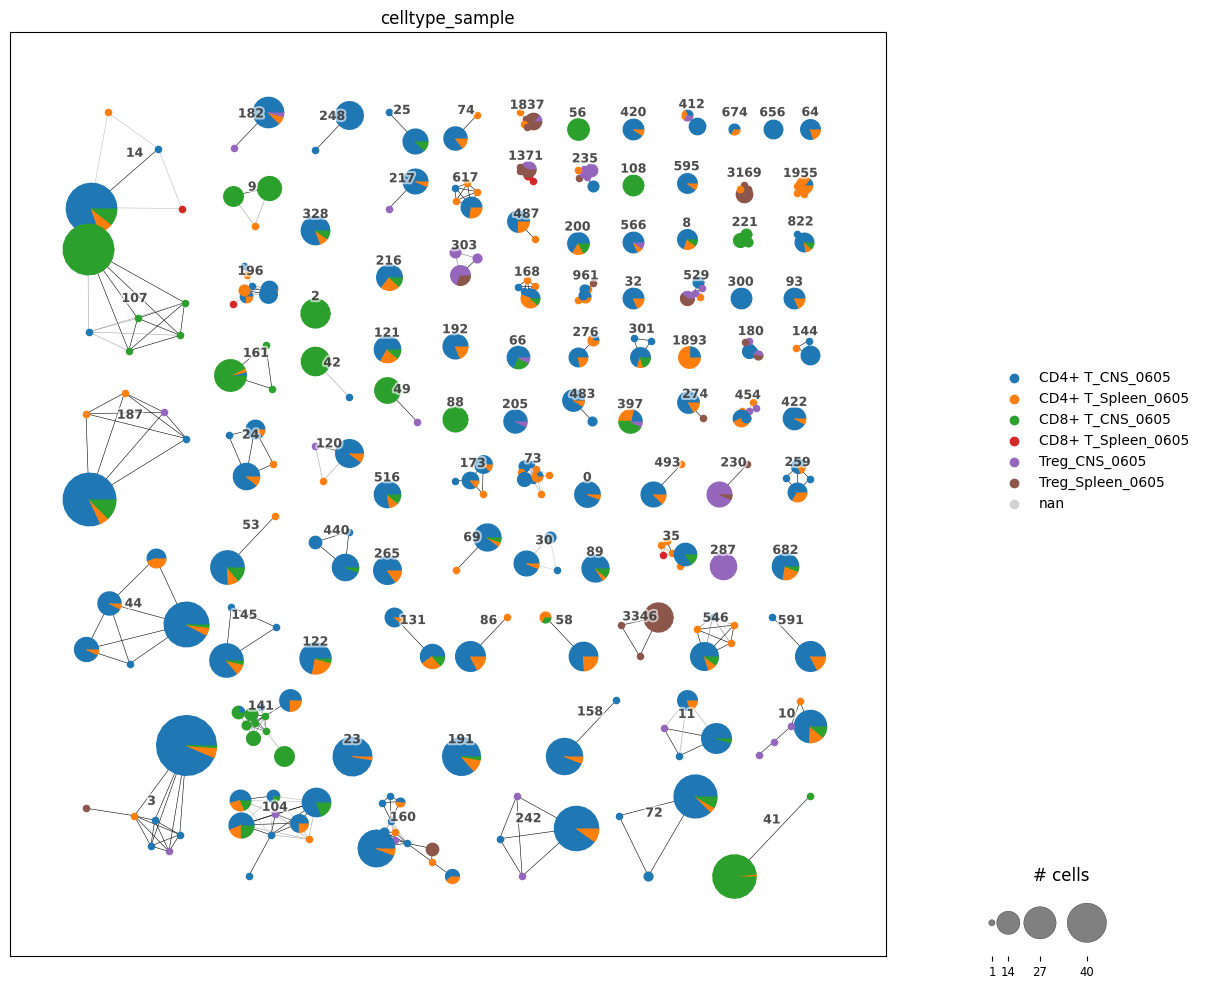

In [166]:
_ = ir.pl.clonotype_network(mdata, color="celltype_sample", label_fontsize=9, panel_size=(12, 12), base_size=20)




### Clonotype modularity

The clonotype modularity measures how densely connected the transcriptomics neighborhood graph underlying the cells in a clonotype is. Clonotypes with a high modularity consist of cells that are **transcriptionally more similar** than that of a clonotype with a low modularity. CNS has higher clonotype modularity than spleen.

In [167]:
#
ir.tl.clonotype_modularity(mdata, target_col="airr:cc_aa_tcrdist")

100%|██████████| 1000/1000 [00:16<00:00, 60.65it/s]


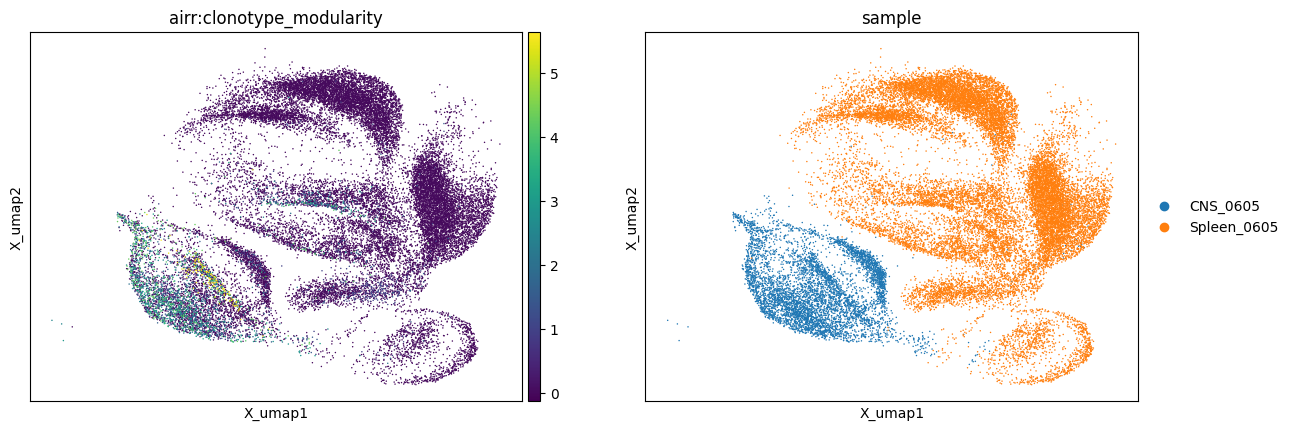

In [168]:
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:clonotype_modularity","sample"])

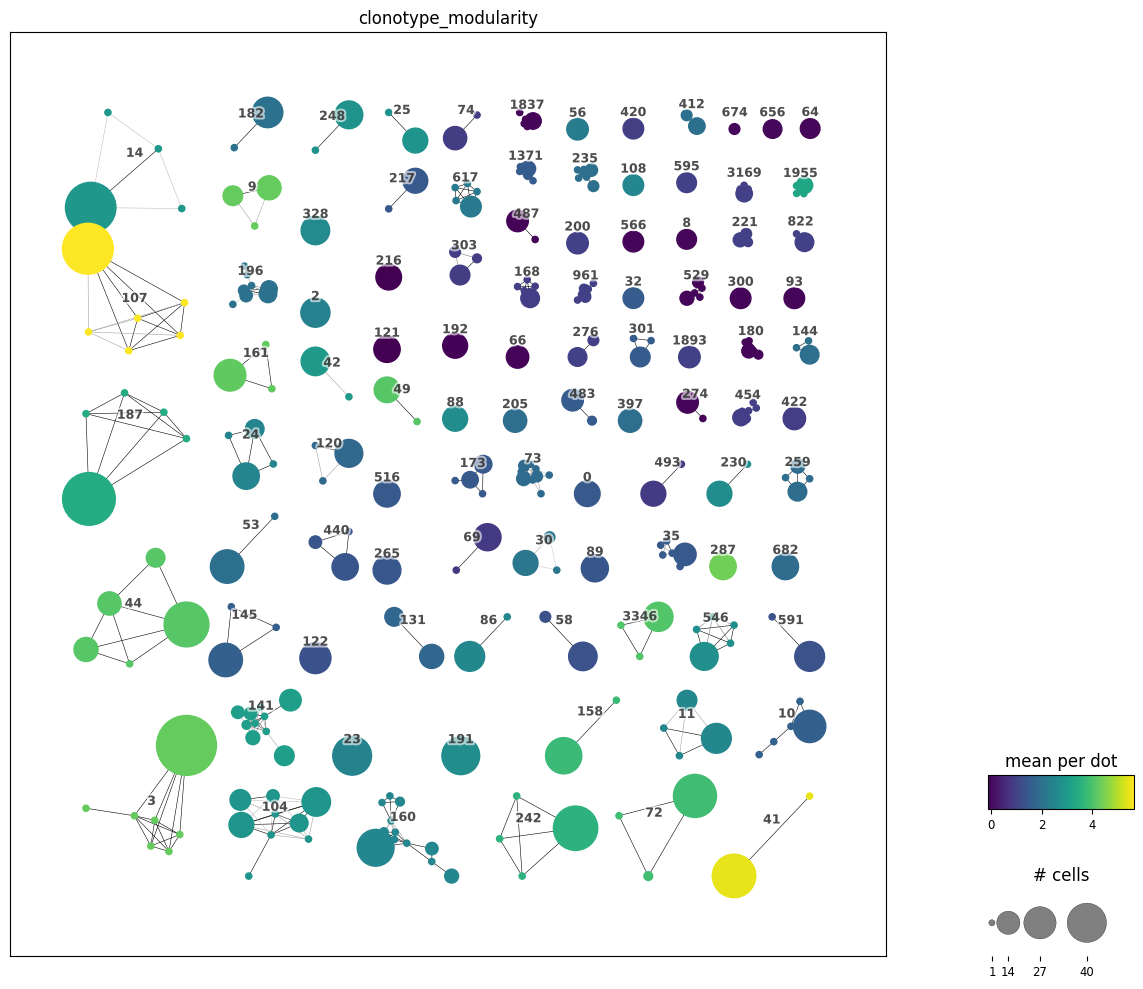

In [183]:
_ = ir.pl.clonotype_network(
    mdata,
    color="clonotype_modularity",
    label_fontsize=9,
    panel_size=(12, 12),
    base_size=20,
)



/tmp/ipykernel_295384/4064169026.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="sample", y="airr:clonotype_modularity", palette="Set2")


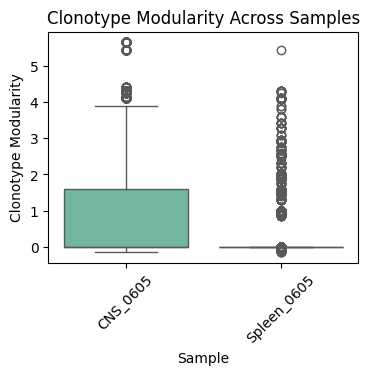

In [187]:
import seaborn as sns
import pandas as pd
mdata.obs["sample"] = mdata.obs["sample"].cat.remove_unused_categories()
# Extract relevant data from mdata_new
df_plot = mdata.obs[["airr:clonotype_modularity", "sample"]].dropna()

# Convert to DataFrame
df_plot = df_plot.astype({"airr:clonotype_modularity": float})

# Create the boxplot
plt.figure(figsize=(4, 3))
sns.boxplot(data=df_plot, x="sample", y="airr:clonotype_modularity", palette="Set2")

plt.xlabel("Sample")
plt.ylabel("Clonotype Modularity")
plt.title("Clonotype Modularity Across Samples")
plt.xticks(rotation=45)  # Rotate labels if needed
plt.show()

### Clonal expansion

CNS has a larger proportion of cells with ≥5 cells sharing the same clone compared to the spleen.

In [171]:
ir.tl.clonal_expansion(mdata)

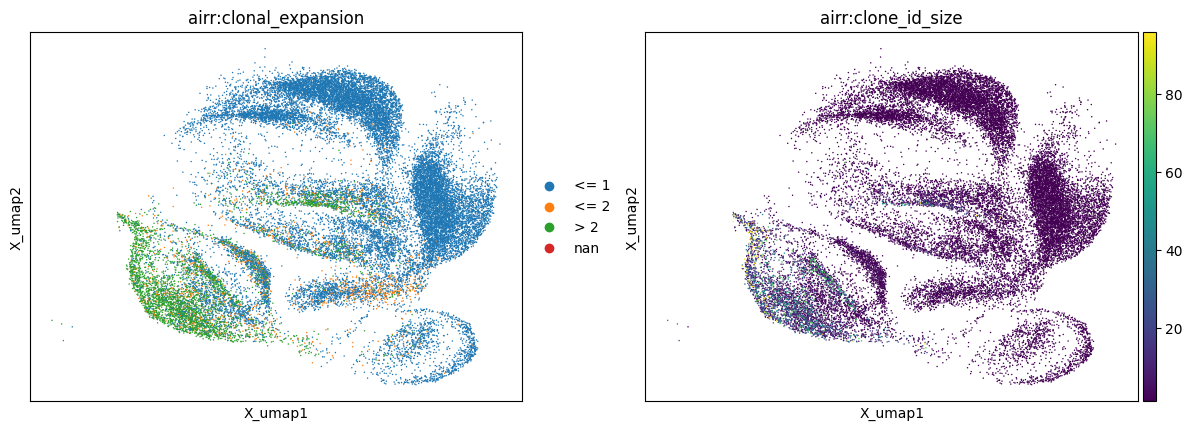

In [172]:
mu.pl.embedding(mdata, basis="gex:umap", color=["airr:clonal_expansion", "airr:clone_id_size"])

/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/scirpy/util/__init__.py:458: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return 1 / cast(np.ndarray, obs.groupby(normalize_col)[normalize_col].transform("count").values)


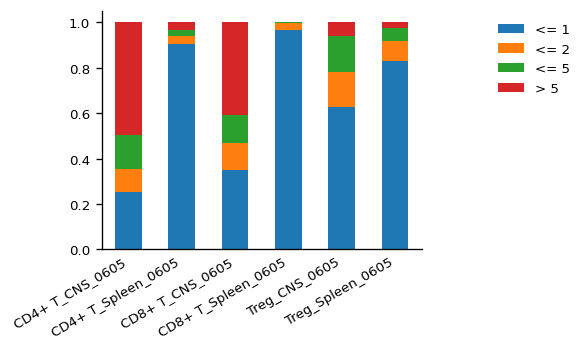

In [173]:
# Perform clonal expansion analysis
_ = ir.pl.clonal_expansion(
    mdata, 
    target_col="clone_id", 
    groupby="celltype_sample",  # Use the new combined column
    breakpoints=(1, 2, 5), 
    #normalize=False
)


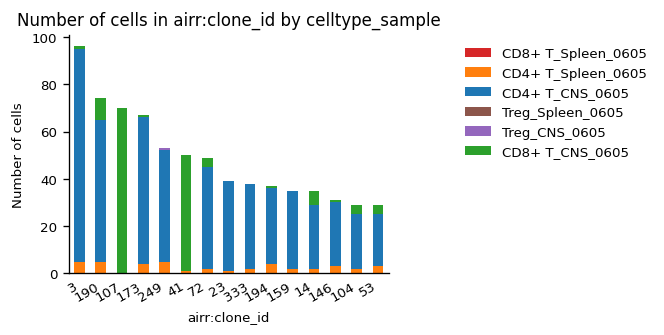

In [174]:
_ = ir.pl.group_abundance(
    mdata,
    groupby="airr:clone_id",
    target_col="celltype_sample",
    max_cols=15,
    #normalize="manual_cell_type",
)

### Motif

Slightly different motif for Treg_CNS_0605 cells and Treg_Spleen_0605 cells

In [175]:
mdata.obs["celltype_sample"].unique()

['CD4+ T_CNS_0605', 'Treg_CNS_0605', 'CD8+ T_CNS_0605', 'Treg_Spleen_0605', 'CD8+ T_Spleen_0605', 'CD4+ T_Spleen_0605']
Categories (6, object): ['CD4+ T_CNS_0605', 'CD4+ T_Spleen_0605', 'CD8+ T_CNS_0605', 'CD8+ T_Spleen_0605', 'Treg_CNS_0605', 'Treg_Spleen_0605']

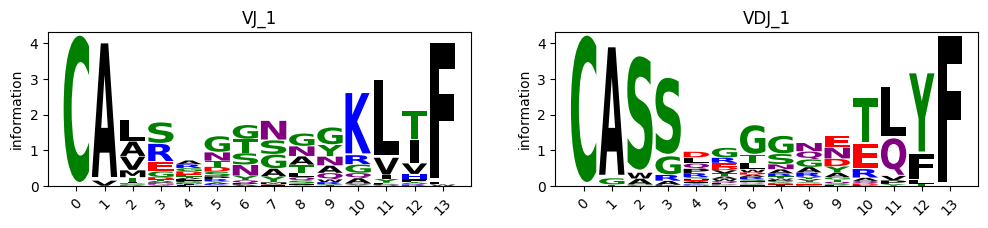

In [178]:
fix, axs = plt.subplots(1, 2, figsize=(12, 2))
for chain, ax in zip(["VJ_1", "VDJ_1"], axs, strict=False):
    ir.pl.logoplot_cdr3_motif(
        mdata[
            (mdata.obs["celltype_sample"] == "Treg_CNS_0605")
            & (ir.get.airr(mdata, "junction_aa", "VDJ_1").str.len() == 14)
            & (ir.get.airr(mdata, "junction_aa", "VJ_1").str.len() == 14)
        ],
        chains=chain,
        to_type="information",
        ax=ax,
    )

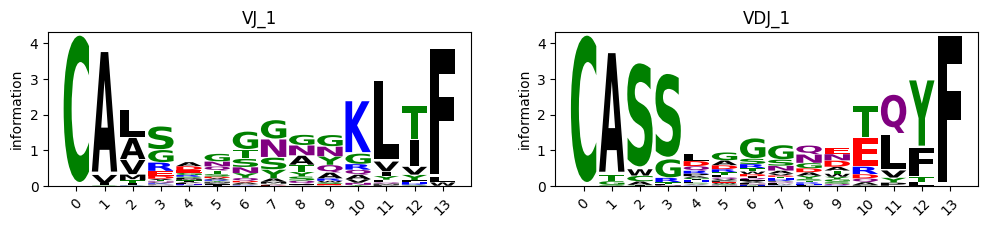

In [180]:
fix, axs = plt.subplots(1, 2, figsize=(12, 2))
for chain, ax in zip(["VJ_1", "VDJ_1"], axs, strict=False):
    ir.pl.logoplot_cdr3_motif(
        mdata_filtered[
            (mdata.obs["celltype_sample"] == "Treg_Spleen_0605")
            & (ir.get.airr(mdata, "junction_aa", "VDJ_1").str.len() == 14)
            & (ir.get.airr(mdata, "junction_aa", "VJ_1").str.len() == 14)
        ],
        chains=chain,
        to_type="information",
        ax=ax,
    )

### DE analysis for high modularity clusters - mostly from CNS

In [181]:
clonotypes_top_modularity = list(
    mdata.obs.set_index("airr:cc_aa_tcrdist")["airr:clonotype_modularity"]
    .sort_values(ascending=False)
    .index.unique()
    .values[:10]
)

In [182]:
clonotypes_top_modularity #['107'-CD8_cns, '41'-CD8_cns, '287' - Treg_cns, '3' - CD4_cns, '9'-CD8_cns, '161'-CD8_cns, '49'-CD8_cns, '44'- CD4_cns, '3346'-Treg_spleen, '72'-CD4_cns]

['107', '41', '287', '3', '9', '161', '49', '44', '3346', '72']

/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")
/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")
/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")
/global/home/users/zhoufd/.conda/envs/TCR/lib/python3.13/site-packages/scanpy/plotting/_tools/__init__.

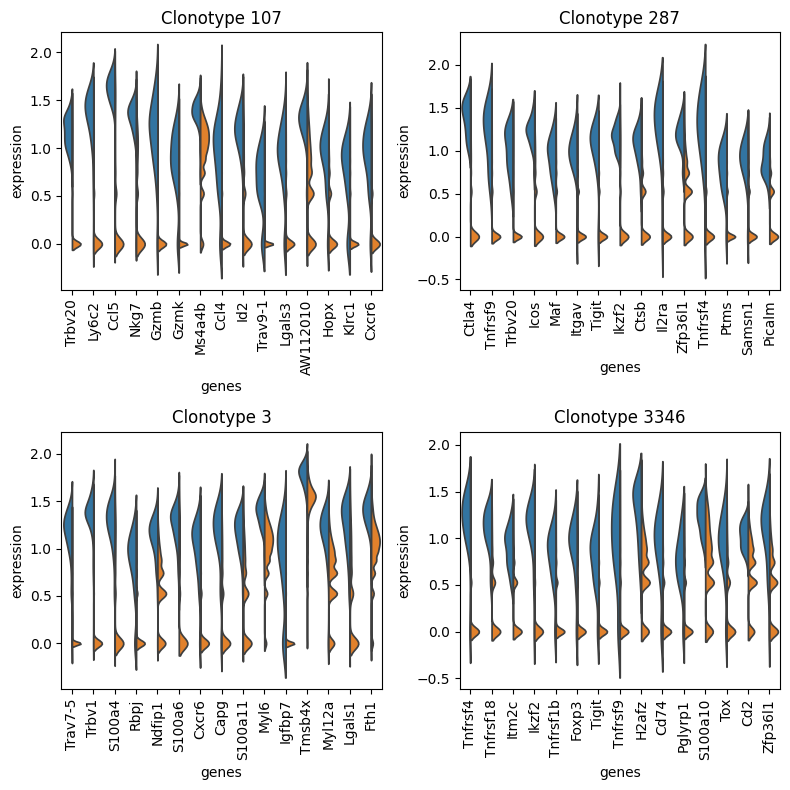

In [186]:
# List of clonotypes to analyze
clonotypes_top_modularity_for_CNS = ['107', '287', '3','3346']

# Set up the context for ranking genes based on clonotype modularity
with ir.get.obs_context(mdata["gex"], {"cc_aa_tcrdist": mdata.obs["airr:cc_aa_tcrdist"]}) as tmp_ad:
    # Perform differential expression analysis using Wilcoxon test
    sc.tl.rank_genes_groups(
        tmp_ad,
        "cc_aa_tcrdist",
        groups=clonotypes_top_modularity_for_CNS,
        reference="rest",
        method="wilcoxon",
    )

    # Dynamically determine the number of rows/columns for subplots
    num_clonotypes = len(clonotypes_top_modularity_for_CNS)
    num_cols = 2  # Number of columns in the figure
    num_rows = int(np.ceil(num_clonotypes / num_cols))  # Number of rows based on total clonotypes

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))  
    axs = axs.flatten()  # Flatten in case of multiple rows

    # Generate violin plots for each clonotype
    for ct, ax in zip(clonotypes_top_modularity_for_CNS, axs):
        sc.pl.rank_genes_groups_violin(tmp_ad, groups=[ct], n_genes=15, ax=ax, show=False, strip=False)
        ax.set_title(f"Clonotype {ct}")  # Add title to each subplot

    # Remove any unused subplots
    for i in range(len(clonotypes_top_modularity_for_CNS), len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()